## Analyse the performance curve (Discard, Tensorboard is all you need)

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import ipdb
import re
import seaborn as sns
import pandas as pd
import pickle
from pprint import pprint
%matplotlib inline

In [ ]:
models = ['HRED', 'MReCoSa', 'MTGCN', 'GatedGCN']    # Add GATRNN
dataset_name = 'dailydialog'
paths = [f'./processed/{dataset_name}/{i}/conclusion.txt' for i in models]
size = 30

In [ ]:
def read_file(path, size=30):
    with open(path) as f:
        bleu1, bleu2, bleu3, bleu4, rouge, dist1, dist2 = [], [], [], [], [], [], []
        EA, VX, GM = [], [], []
        for line in f.readlines():
            line = line.strip()
            if 'BLEU-1' in line:
                bleu1.append(float(line.replace('BLEU-1: ', '')))
            elif 'BLEU-2' in line:
                bleu2.append(float(line.replace('BLEU-2: ', '')))
            elif 'BLEU-3' in line:
                bleu3.append(float(line.replace('BLEU-3: ', '')))
            elif 'BLEU-4' in line:
                bleu4.append(float(line.replace('BLEU-4: ', '')))
            elif 'ROUGE' in line:
                rouge.append(float(line.replace('ROUGE: ', '')))
            elif 'Distinct' in line:
                distinct1, distinct2 = line.split(';')
                dist1.append(float(distinct1.replace('Distinct-1: ', '').strip()))
                dist2.append(float(distinct2.replace('Distinct-2: ', '').strip()))
            elif 'EA' in line:
                EA.append(float(line.replace('EA: ', '')))
            elif 'VX' in line:
                VX.append(float(line.replace('VX: ', '')))
            # elif 'GM' in line:
            #     GM.append(float(line.replace('GM: ', '')))
    assert len(bleu1) == size, f'{len(bleu1)} -- {size}'
    assert len(bleu2) == size, f'{len(bleu2)} -- {size}'
    assert len(bleu3) == size, f'{len(bleu3)} -- {size}'
    assert len(bleu4) == size, f'{len(bleu4)} -- {size}'
    assert len(rouge) == size, f'{len(rouge)} -- {size}'
    assert len(dist1) == size, f'{len(dist1)} -- {size}'
    assert len(dist2) == size, f'{len(dist2)} -- {size}'
    assert len(EA) == size, f'{len(EA)} -- {size}'
    assert len(VX) == size, f'{len(VX)} -- {size}'
    # assert len(GM) == size, f'{len(GM)} -- {size}'
    return (bleu1, bleu2, bleu3, bleu4, rouge, dist1, dist2, EA, VX)

In [ ]:
def draw_curve(ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9,
               bleu1, bleu2, bleu3, bleu4, rouge, dist1, dist2, ea, vx, m):
    x = np.arange(1, size + 1)
    
    ax1.plot(x, bleu1, label=m)
    ax1.legend()
    ax1.set_title('BLEU-1')
    
    ax2.plot(x, bleu2, label=m)
    ax2.legend()
    ax2.set_title('BLEU-2')
    
    ax3.plot(x, bleu3, label=m)
    ax3.legend()
    ax3.set_title('BLEU-3')
    
    ax4.plot(x, bleu4, label=m)
    ax4.legend()
    ax4.set_title('BLEU-4')
    
    ax5.plot(x, rouge, label=m)
    ax5.legend()
    ax5.set_title('ROUGE')
    
    ax6.plot(x, dist1, label=m)
    ax6.legend()
    ax6.set_title('Distinct-1')
    
    ax7.plot(x, dist2, label=m)
    ax7.legend()
    ax7.set_title('Distinct-2')
    
    ax8.plot(x, ea, label=m)
    ax8.legend()
    ax8.set_title('Embedding Average')
    
    ax9.plot(x, vx, label=m)
    ax9.legend()
    ax9.set_title('Vector Extrema')

In [ ]:
def meta_data(bar, data):
    try:
        print(f'{bar}: Max data {np.max(data)}, epoch: {1 + np.argmax(data)}')
    except:
        return 

In [ ]:
dataset = []
for m, path in zip(models, paths):
    print(f'========== {m} : {path} ==========')
    data = read_file(path, size=size)
    if data:
        dataset.append(data)
        meta_data('BLEU-1', data[0])
        meta_data('BLEU-2', data[1])
        meta_data('BLEU-3', data[2])
        meta_data('BLEU-4', data[3])
        meta_data('ROUGE',  data[4])
        meta_data('Dist-1', data[5])
        meta_data('Dist-2', data[6])
        meta_data('Embedding Average', data[7])
        meta_data('Vector Extrema', data[8])
        # meta_data('Greedy Matching', data[9])

In [ ]:
plt.figure(figsize=(10, 20))
sub = [plt.subplot(5, 2, 1), plt.subplot(5, 2, 2), plt.subplot(5, 2, 3),
       plt.subplot(5, 2, 4), plt.subplot(5, 2, 5), plt.subplot(5, 2, 6), 
       plt.subplot(5, 2, 7), plt.subplot(5, 2, 8), plt.subplot(5, 2, 9),]

for d, m in zip(dataset, models):
    draw_curve(*sub, *d, m)
    
plt.savefig(f'./img/{dataset_name}.png')

## Show the PPL Perturbation

refer to the ACL 2019 short paper: `Do Neural Dialog Systems Use the Conversation History Effectively? An Empirical Study`

In [198]:
models = ['HRED', 'DSHRED', 'WSeq', 'MReCoSa', 'VHRED', 
          'HRAN', 'DSHRED_RA', 'WSeq_RA', 'MReCoSa_RA',
          'Seq2Seq', 'Seq2Seq_MHA']    # Add GATRNN
dataset_name = 'personachat'
paths = [f'./processed/{dataset_name}/{i}/pertub-ppl.txt' for i in models]

model = 'WSeq'
path = paths[models.index(model)]

In [199]:
def read_ppl(path):
    real = re.compile(r'.*loss: (\w+\.\w+), PPL: (\w+\.\w+).*')
    with open(path) as f:
        loss, ppl = [], []
        for line in f.readlines():
            line = line.strip()
            loss_, ppl_ = real.findall(line)[0]
            loss_, ppl_ = float(loss_), float(ppl_)
            loss.append(loss_)
            ppl.append(ppl_)
    return loss, ppl

In [200]:
loss, ppl = read_ppl(path)
ppl[5] = 0
data = pd.DataFrame.from_dict({model: ppl}, orient='index', 
                              columns=['Origin', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
data

,Origin,1,2,3,4,5,6,7,8,9,10
WSeq,37.3936,80.2382,92.0563,37.5848,167.9893,0,51.8264,65.7724,48.7595,41.9593,41.0011


Whole Perbuturbation:
 [0.0, 42.8446, 54.6627, 0.1912, 130.5957, -37.3936, 14.4328, 28.3788, 11.3659, 4.5657, 3.6075]
Original PPL: 37.3936
Max Perturbation: 130.5957, 4
Min Perturbation: -37.3936, 5
Mean Perturbation: 25.3251


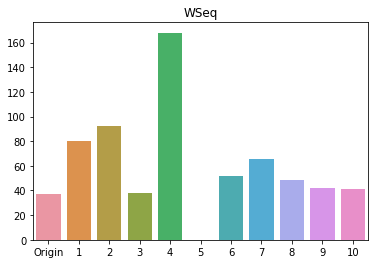

In [201]:
sns.barplot(data=data)
plt.title(f'{model}')
plt.savefig(f'./img/{dataset_name}-{model}-perturbation.png')

# show the count of the perturbation
count = np.array(ppl) - np.array([ppl[0]] * len(ppl))
count = count.tolist()
count = [round(i, 4) for i in count]
print(f'Whole Perbuturbation:\n {count}')
print(f'Original PPL: {round(ppl[0], 4)}')
print(f'Max Perturbation: {round(max(count[1:]), 4)}, {np.argmax(count[1:])+1}')
print(f'Min Perturbation: {round(min(count[1:]), 4)}, {np.argmin(count[1:])+1}')
print(f'Mean Perturbation: {round(np.mean(count[1:]), 4)}')

### Dailydialog
Seq2Seq
Whole Perbuturbation:
 [0.0, 20.525, 27.1865, 5.8573, 58.1082, 19.8178, 9.5296, 13.6601, 6.7657, 5.3018, 3.9896]
Original PPL: 25.4547
Max Perturbation: 58.1082, 4
Min Perturbation: 3.9896, 10
Mean Perturbation: 17.0742

Seq2Seq-MHA
Whole Perbuturbation:
 [0.0, 15.8091, 21.7254, -6.5134, 69.357, 12.4842, 2.1211, 9.3529, -3.0175, -7.2258, -7.7631]
Original PPL: 41.285
Max Perturbation: 69.357, 4
Min Perturbation: -7.7631, 10
Mean Perturbation: 10.633

---

HRED:
Whole Perbuturbation:
 [0.0, 23.0511, 29.1686, 1.3785, 63.1539, 6.0026, 10.1744, 14.051, 6.7113, 4.292, 3.4476]
Original PPL: 32.3722
Max Perturbation: 63.1539, 4
Min Perturbation: 1.3785, 3
Mean Perturbation: 16.1431

WSeq:
Whole Perbuturbation:
 [0.0, 19.1049, 25.2033, 1.3737, 55.4901, 5.6383, 7.8153, 11.5796, 5.3479, 3.4189, 3.2854]
Original PPL: 33.7473
Max Perturbation: 55.4901, 4
Min Perturbation: 1.3737, 3
Mean Perturbation: 13.8257

DSHRED:
Whole Perbuturbation:
 [0.0, 27.8725, 37.6236, 3.0022, 84.5578, 12.2294, 16.3333, 21.6096, 9.6054, 5.9065, 5.1542]
Original PPL: 35.1421
Max Perturbation: 84.5578, 4
Min Perturbation: 3.0022, 3
Mean Perturbation: 22.3894
    
ReCoSa:
Whole Perbuturbation:
 [0.0, 40.5579, 54.9294, 1.7795, 114.1991, 8.2215, 15.3906, 22.6993, 10.1804, 7.4336, 5.1857]
Original PPL: 33.2083
Max Perturbation: 114.1991, 4
Min Perturbation: 1.7795, 3
Mean Perturbation: 28.0577


---
    
HRAN(HRED-WA):
Whole Perbuturbation:
 [0.0, 25.8675, 34.2801, 2.5925, 71.5624, 12.536, 18.1876, 24.3738, 11.344, 7.6625, 6.8348]
Original PPL: 31.2494
Max Perturbation: 71.5624, 4
Min Perturbation: 2.5925, 3
Mean Perturbation: 21.5241

DSHRED-WA
Whole Perbuturbation:
 [0.0, 30.8531, 38.351, 5.1927, 73.8188, 18.9551, 20.9557, 27.8234, 12.4998, 10.5894, 7.9644]
Original PPL: 31.8807
Max Perturbation: 73.8188, 4
Min Perturbation: 5.1927, 3
Mean Perturbation: 24.7003

WSeq-WA:
Whole Perbuturbation:
 [0.0, 31.4608, 48.6565, 2.502, 85.6396, 12.7841, 18.4905, 25.2946, 10.0103, 8.7952, 6.7164]
Original PPL: 30.9663
Max Perturbation: 85.6396, 4
Min Perturbation: 2.502, 3
Mean Perturbation: 25.035

ReCoSa-WA

### EmpChat
Seq2Seq
Whole Perbuturbation:
 [0.0, 13.9974, 23.2781, 10.9577, 73.1063, 13.5592, 3.7601, 4.331, 4.7258, 2.6418, 2.8945]
Original PPL: 48.818
Max Perturbation: 73.1063, 4
Min Perturbation: 2.6418, 9
Mean Perturbation: 15.3252

Seq2Seq-MHA
Whole Perbuturbation:
 [0.0, 18.7698, 21.6345, 12.0634, 66.5782, 14.4877, 4.7815, 5.4818, 5.7803, 2.308, 2.7465]
Original PPL: 46.74
Max Perturbation: 66.5782, 4
Min Perturbation: 2.308, 9
Mean Perturbation: 15.4632

---

HRED:
Whole Perbuturbation:
 [0.0, 19.3327, 21.6962, 8.7165, 71.9187, 10.7468, 4.5383, 5.5236, 4.3128, 1.702, 1.9111]
Original PPL: 46.8289
Max Perturbation: 71.9187, 4
Min Perturbation: 1.702, 9
Mean Perturbation: 15.0399

WSeq: 
Whole Perbuturbation:
 [0.0, 25.6956, 30.1524, 17.5288, 97.8734, 23.8943, 8.8247, 9.0257, 9.3157, 3.618, 3.4286]
Original PPL: 53.8714
Max Perturbation: 97.8734, 4
Min Perturbation: 3.4286, 10
Mean Perturbation: 22.9357

DSHRED:
Whole Perbuturbation:
 [0.0, 18.1944, 19.7997, 11.1095, 73.8565, 13.6776, 4.4843, 5.3088, 4.5, 1.8542, 1.9582]
Original PPL: 47.6175
Max Perturbation: 73.8565, 4
Min Perturbation: 1.8542, 9
Mean Perturbation: 15.4743
    
ReCoSa:
Whole Perbuturbation:
 [0.0, 17.8516, 21.5708, 6.553, 64.731, 7.3616, 3.7862, 6.2351, 4.0056, 1.7894, 1.8594]
Original PPL: 44.8759
Max Perturbation: 64.731, 4
Min Perturbation: 1.7894, 9
Mean Perturbation: 13.5744

---
    
HRAN
Whole Perbuturbation:
 [0.0, 20.8905, 23.7996, 10.4145, 68.1211, 13.2406, 7.1619, 10.0035, 6.6166, 3.3192, 2.9016]
Original PPL: 51.1263
Max Perturbation: 68.1211, 4
Min Perturbation: 2.9016, 10
Mean Perturbation: 16.6469

DSHRED-WA
Whole Perbuturbation:
 [0.0, 18.5751, 21.6126, 10.9574, 67.6559, 13.4834, 6.3681, 8.0072, 6.6509, 3.4078, 3.0425]
Original PPL: 48.95
Max Perturbation: 67.6559, 4
Min Perturbation: 3.0425, 10
Mean Perturbation: 15.9761

WSeq-WA
Whole Perbuturbation:
 [0.0, 13.6866, 18.8411, 10.3985, 70.1269, 13.5904, 6.3891, 7.6462, 5.2749, 2.7755, 2.2854]
Original PPL: 46.479
Max Perturbation: 70.1269, 4
Min Perturbation: 2.2854, 10
Mean Perturbation: 15.1015

ReCoSa-WA
Whole Perbuturbation:
 [0.0, 3.4346, 3.74, 5.4611, 16.1091, 6.1617, 3.2205, 3.8104, 4.78, 2.6719, 2.042]
Original PPL: 46.4743
Max Perturbation: 16.1091, 4
Min Perturbation: 2.042, 10
Mean Perturbation: 5.1431

#### PersonaChat
Seq2Seq
Whole Perbuturbation:
 [0.0, 52.8044, 62.3695, 0.3511, 138.5526, -37.5735, 12.5355, 18.228, 11.6662, 4.9646, 2.9062]
Original PPL: 37.5735
Max Perturbation: 138.5526, 4
Min Perturbation: -37.5735, 5
Mean Perturbation: 26.6805

Seq2Seq-MHA

---

HRED

WSeq:
Whole Perbuturbation:
 [0.0, 42.8446, 54.6627, 0.1912, 130.5957, -37.3936, 14.4328, 28.3788, 11.3659, 4.5657, 3.6075]
Original PPL: 37.3936
Max Perturbation: 130.5957, 4
Min Perturbation: -37.3936, 5
Mean Perturbation: 25.3251

DSHRED:
Whole Perbuturbation:
 [0.0, 40.2694, 36.9069, 0.294, 124.2415, 95.8922, 18.4619, 26.4675, 14.1525, 5.2536, 3.8176]
Original PPL: 36.1472
Max Perturbation: 124.2415, 4
Min Perturbation: 0.294, 3
Mean Perturbation: 36.5757
    
ReCoSa

---
    
HRAN
Whole Perbuturbation:
 [0.0, 7.7532, 11.6463, 0.4562, 8.1324, 64.6435, 11.1158, 19.6202, 6.5852, 3.6531, 2.086]
Original PPL: 32.8319
Max Perturbation: 64.6435, 5
Min Perturbation: 0.4562, 3
Mean Perturbation: 13.5692

DSHRED-WA

WSeq-WA

ReCoSa-WA

#### DSTC7
Seq2Seq

Seq2Seq-MHA

---

HRED

WSeq:

VHRED:

DSHRED:
    
ReCoSa

---
    
HRAN

DSHRED-WA

WSeq-WA

ReCoSa-WA

#### Ubuntu
Seq2Seq

Seq2Seq-MHA

---

HRED

WSeq:

VHRED:

DSHRED:
    
ReCoSa:

---
    
HRAN

DSHRED-WA

WSeq-WA

ReCoSa-WA

## Attention Heatmap

In [212]:
def plot_heatmap(a, inwords, outwords):
    # plot 2 heatmap
    # refer to document from matplotlib
    # https://matplotlib.org/gallery/axes_grid1/demo_axes_divider.html#sphx-glr-gallery-axes-grid1-demo-axes-divider-py
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    plt.figure(figsize=(20, 10))
    ax = plt.subplot()
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="2%", pad=0.2)
    fig1 = ax.get_figure()
    fig1.add_axes(ax_cb)
    
    # attention map
    im = ax.imshow(a, cmap='hot', vmin=0, vmax=1, interpolation='nearest')
    
    # set the ticks
    ax.set_yticks(range(len(outwords)))
    ax.set_yticklabels(outwords, fontsize=20)
    ax.set_xticks(range(len(inwords)))
    ax.set_xticklabels(inwords)
    for label in ax.xaxis.get_ticklabels():
        label.set_rotation(45)
        label.set_fontsize(20)
        
    # colorbar
    plt.colorbar(im, cax=ax_cb)
    ax_cb.yaxis.tick_right()
    ax_cb.yaxis.set_tick_params(labelright=True)
    ax.set_title('Attention Heatmap', fontsize=20)
    
    plt.savefig(f"./img/attention_heatmap.png")

In [213]:
def load_pickle(dataset, model, string):
    # string is the special control tokens
    path = f'processed/{dataset}/{model}/attention_heatmap_{string}.pkl'
    with open(path,' rb') as f:
        data = pickle.load(f)
    am, iw, ow = data
    return am, iw, ow

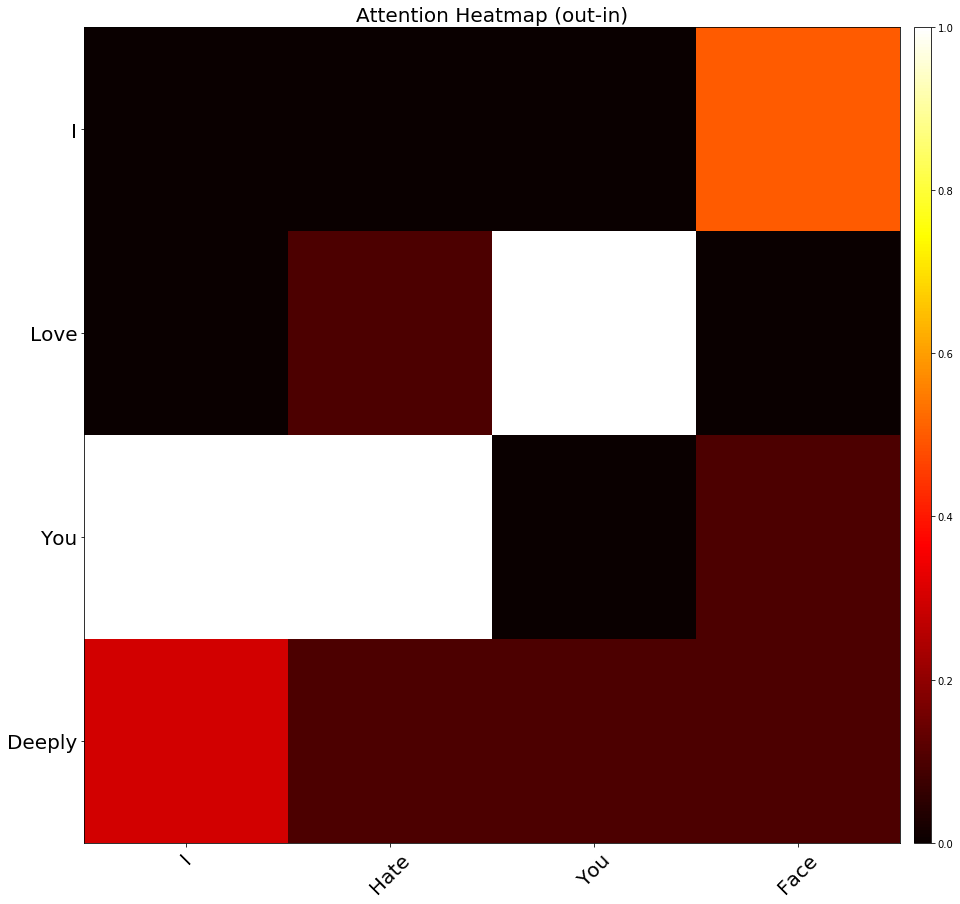

In [210]:
dataset, model = 'dailydialog', 'HRAN'